## Background
- The dataset contains EURUSD currency pair historical chart of 5 minutes from 1st of August, 2023 to 1st of March, 2024. The dataset was sourced from financialmodelingprep.com

### Problem statement
- The goal is to create a model that can make predictions with a high degree of accuracy, reducing the uncertainty around future currency pair movements.

In [139]:
# IMPORTING PACKAGES

import requests
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored as cl
import numpy as np
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

In [140]:
# EXTRACTING HISTORICAL DATA
api_key = 'Kb5zKb60jox0mteprQipBr8nMOZlf9FG'
url = f'https://financialmodelingprep.com/api/v3/historical-chart/5min/EURUSD?from=2023-08-10&to=2024-03-10&apikey={api_key}'
EURUSD_json = requests.get(url).json()

# Print the response to understand its structure
df = pd.DataFrame(EURUSD_json)
df

,date,open,low,high,close,volume
0,2024-03-10 23:55:00,1.09442,1.0939,1.09442,1.09412,319
1,2024-03-10 23:50:00,1.09420,1.0942,1.09443,1.09443,234
2,2024-03-10 23:45:00,1.09437,1.0942,1.09442,1.09442,309
3,2024-03-10 23:40:00,1.09400,1.0940,1.09440,1.09436,349
4,2024-03-10 23:35:00,1.09417,1.0939,1.09422,1.09418,272
...,...,...,...,...,...,...
1706,2024-03-01 00:20:00,1.08119,1.0809,1.08130,1.08120,332
1707,2024-03-01 00:15:00,1.08120,1.0810,1.08120,1.08118,268
1708,2024-03-01 00:10:00,1.08117,1.0810,1.08130,1.08118,278
1709,2024-03-01 00:05:00,1.08130,1.0810,1.08130,1.08115,299


## Data Inspection

In [141]:
# shape of dataset
df.shape

(1711, 6)

In [142]:
# check columns
df.columns.tolist()

['date', 'open', 'low', 'high', 'close', 'volume']

In [143]:
# the info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1711 non-null   object 
 1   open    1711 non-null   float64
 2   low     1711 non-null   float64
 3   high    1711 non-null   float64
 4   close   1711 non-null   float64
 5   volume  1711 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 80.3+ KB


In [144]:
# check the data types
df.dtypes

date       object
open      float64
low       float64
high      float64
close     float64
volume      int64
dtype: object

In [145]:
# check for duplicates
df.duplicated().sum()

0

In [146]:
# check for missing values
df.isnull().sum()

date      0
open      0
low       0
high      0
close     0
volume    0
dtype: int64

In [147]:
# summary statistics of the data
df.describe().astype('int')

,open,low,high,close,volume
count,1711,1711,1711,1711,1711
mean,1,1,1,1,547
std,0,0,0,0,283
min,1,1,1,1,16
25%,1,1,1,1,332
50%,1,1,1,1,504
75%,1,1,1,1,727
max,1,1,1,1,1893


*The average volume is 547, with a minimum volume is 16 and a maximum volume of 1893. 75% of the data has a volume below 727, while the remaining 25% has a volume between 727 and 1893.*

## Data Cleaning and Preprocessing

In [148]:
# select numerical variables
num_vars = df.select_dtypes(include = ['float', 'int64']).columns.tolist()
print(num_vars)

# value counts for numerical variables
for column in num_vars:
    print(df[column].value_counts())

['open', 'low', 'high', 'close', 'volume']
open
1.08500    11
1.08510    10
1.08520     9
1.08958     9
1.08525     9
           ..
1.09071     1
1.09074     1
1.09041     1
1.09051     1
1.08132     1
Name: count, Length: 774, dtype: int64
low
1.08500    52
1.08490    52
1.08480    46
1.08540    46
1.08510    42
           ..
1.08968     1
1.08964     1
1.08967     1
1.08961     1
1.08096     1
Name: count, Length: 247, dtype: int64
high
1.08570    38
1.08990    28
1.09480    26
1.08580    26
1.08520    25
           ..
1.08992     1
1.09061     1
1.09072     1
1.09036     1
1.08123     1
Name: count, Length: 653, dtype: int64
close
1.08510    15
1.08530    14
1.08520    12
1.08970    11
1.09470    10
           ..
1.08672     1
1.08662     1
1.08655     1
1.08682     1
1.09617     1
Name: count, Length: 762, dtype: int64
volume
328     9
313     8
518     7
410     7
325     6
       ..
1249    1
1351    1
1075    1
1120    1
183     1
Name: count, Length: 847, dtype: int64


In [149]:
# select categorical variables
cat_vars = df.select_dtypes(include = ['object']).columns.tolist()
print(cat_vars)

# value counts for categorical variables
for column in cat_vars:
    print(df[column].value_counts())

['date']
date
2024-03-10 23:55:00    1
2024-03-04 23:00:00    1
2024-03-04 23:10:00    1
2024-03-04 23:15:00    1
2024-03-04 23:20:00    1
                      ..
2024-03-06 23:30:00    1
2024-03-06 23:35:00    1
2024-03-06 23:40:00    1
2024-03-06 23:45:00    1
2024-03-01 00:00:00    1
Name: count, Length: 1711, dtype: int64


Percentage of missing values: date      0.0
open      0.0
low       0.0
high      0.0
close     0.0
volume    0.0
dtype: float64%

Missing value count per column:
date      0
open      0
low       0
high      0
close     0
volume    0
dtype: int64


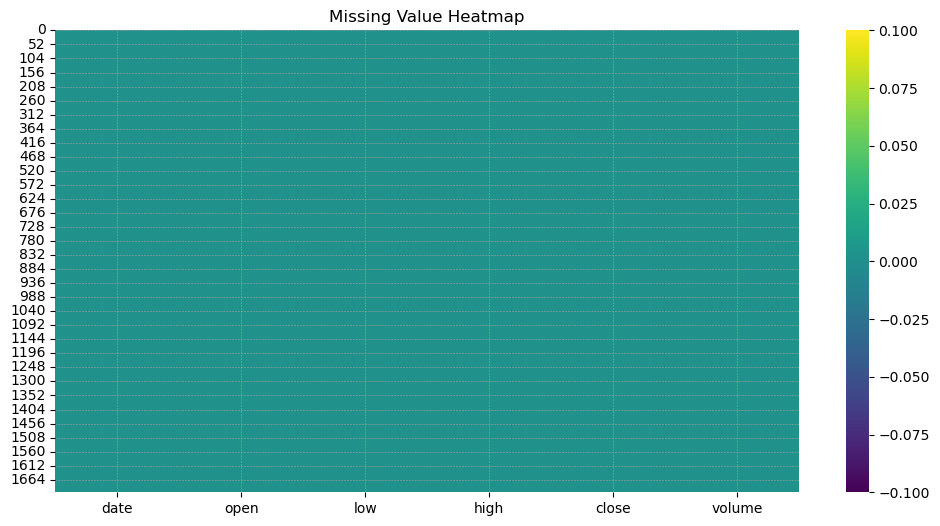

In [150]:
# Check for missing values
# Check the overall missing value percentage
print(f"Percentage of missing values: {df.isnull().mean().round(4) * 100}%")

# Check the missing value count for each column
print("\nMissing value count per column:")
print(df.isnull().sum())

# Visualize the missing value pattern
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

## Exploratory Data Analysis

#### Univariate Analysis
- checking the distribution of each singular feature and its visualization.

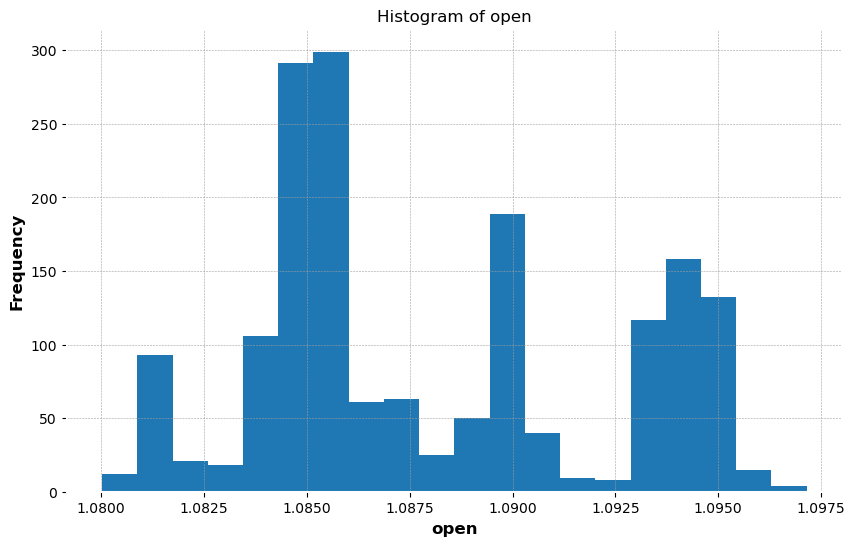

Summary statistics for 'open':
count    1711.000000
mean        1.088030
std         0.004259
min         1.080020
25%         1.084905
50%         1.086120
75%         1.092805
max         1.097150
Name: open, dtype: float64


In [151]:
# Numerical features
numeric_col1 = 'open'

# Histogram
plt.figure(figsize=(10, 6))
df[numeric_col1].hist(bins=20)
plt.title(f"Histogram of {numeric_col1}")
plt.xlabel(numeric_col1)
plt.ylabel("Frequency")
plt.show()

# Summary statistics
summary_stats = df['open'].describe()
print("Summary statistics for 'open':")
print(summary_stats)

*The summary indicates a right-skewed distribution with most observations clustered around a median value of approximately -2.494. However, there are noticeable deviations towards lower values, especially evident in the histogram, indicating a stretched distribution towards the lower end. This suggests that while the majority of observations lie slightly below the median, there's a smaller portion deviating towards lower values, contributing to the overall skewness.*

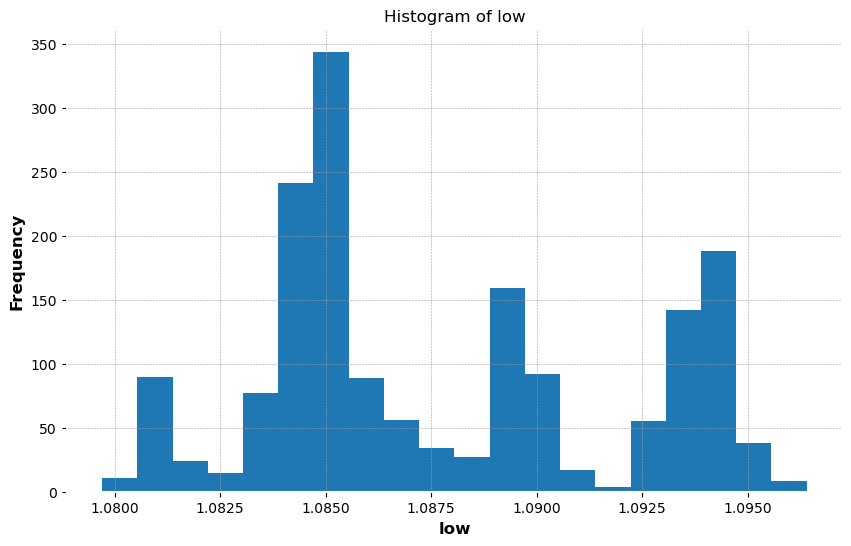

Summary statistics for 'low':
count    1711.000000
mean        1.087768
std         0.004257
min         1.079700
25%         1.084600
50%         1.085800
75%         1.092450
max         1.096400
Name: low, dtype: float64


In [152]:
# Numerical features
numeric_col2 = 'low'

# Histogram
plt.figure(figsize=(10, 6))
df[numeric_col2].hist(bins=20)
plt.title(f"Histogram of {numeric_col2}")
plt.xlabel(numeric_col2)
plt.ylabel("Frequency")
plt.show()

# Summary statistics
summary_stats = df['low'].describe()
print("Summary statistics for 'low':")
print(summary_stats)

*The summary statistics for 'low' indicate a slightly right-skewed distribution, with most observations clustered around a median value of approximately -2.497. However, there are noticeable deviations towards lower values, as evidenced by the stretched distribution towards the lower end in the histogram. While the majority of observations lie slightly below the median, there's a smaller portion deviating towards lower values, contributing to the overall right skewness of the data.*

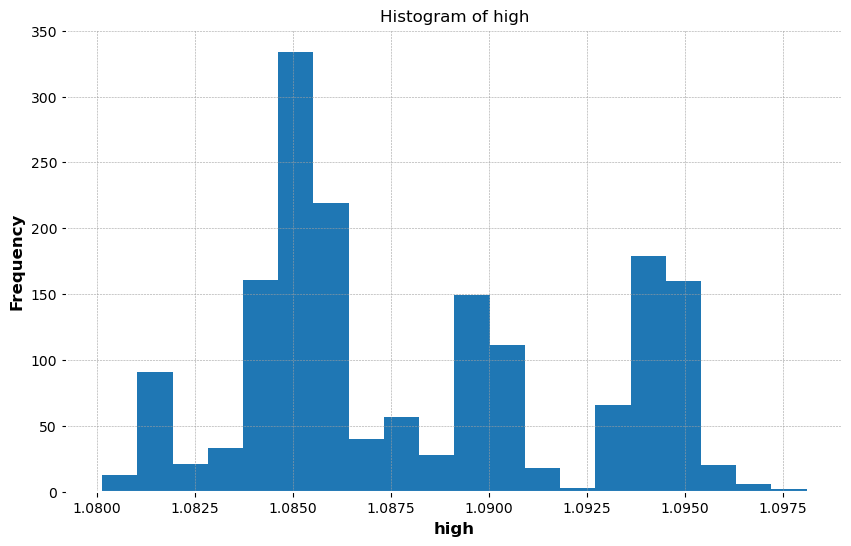

Summary statistics for 'high':
count    1711.000000
mean        1.088188
std         0.004265
min         1.080140
25%         1.085010
50%         1.086300
75%         1.093015
max         1.098100
Name: high, dtype: float64


In [153]:
# Numerical features
numeric_col3 = 'high'

# Histogram
plt.figure(figsize=(10, 6))
df[numeric_col3].hist(bins=20)
plt.title(f"Histogram of {numeric_col3}")
plt.xlabel(numeric_col3)
plt.ylabel("Frequency")
plt.show()

# Summary statistics
summary_stats = df['high'].describe()
print("Summary statistics for 'high':")
print(summary_stats)

*The summary statistics for 'high' also suggest a slightly right-skewed distribution, with most observations clustered around a median value of approximately -2.492. Similar to the 'open' and 'low' columns, there are noticeable deviations towards lower values, as indicated by the stretched distribution towards the lower end in the histogram. While the majority of observations lie slightly below the median, there's a smaller portion deviating towards lower values, contributing to the overall right skewness of the data.*

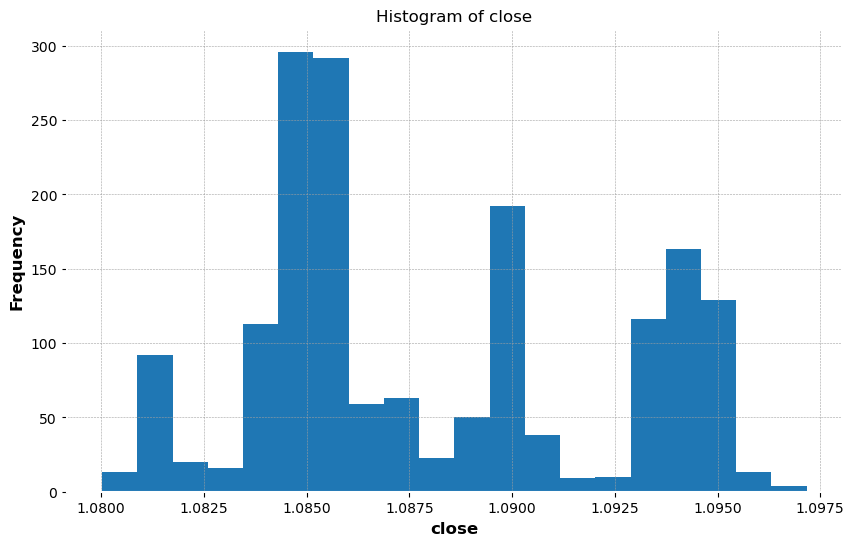

Summary statistics for 'close':
count    1711.000000
mean        1.088035
std         0.004260
min         1.080020
25%         1.084900
50%         1.086150
75%         1.092820
max         1.097170
Name: close, dtype: float64


In [154]:
# Numerical features
numeric_col4 = 'close'

# Histogram
plt.figure(figsize=(10, 6))
df[numeric_col4].hist(bins=20)
plt.title(f"Histogram of {numeric_col4}")
plt.xlabel(numeric_col4)
plt.ylabel("Frequency")
plt.show()

# Summary statistics
summary_stats = df['close'].describe()
print("Summary statistics for 'close':")
print(summary_stats)

*The summary statistics for 'close' reveal a distribution slightly skewed to the right, with most observations clustered around the median value of approximately -2.493. The histogram visually depicts this skewness, with the distribution stretching towards lower values. While the majority of observations lie slightly below the median, there is a smaller portion of data deviating towards lower values, contributing to the overall right skewness of the data distribution.*

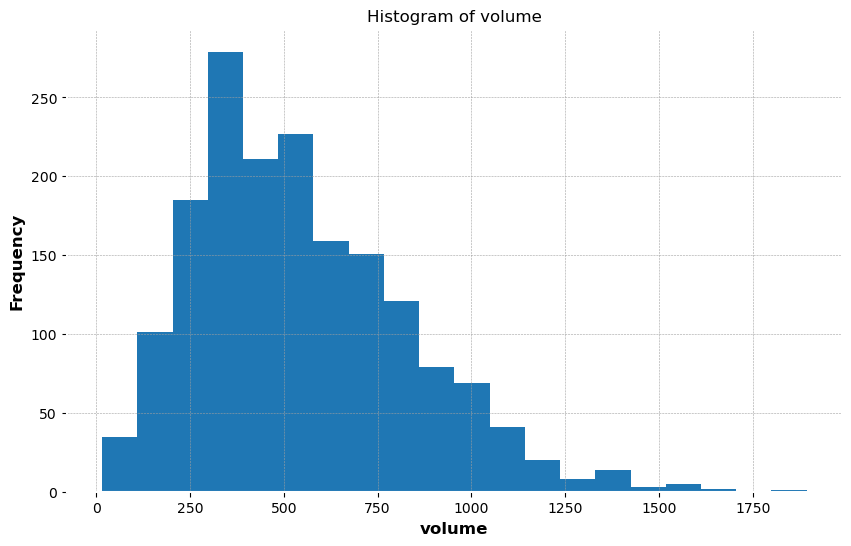

Summary statistics for 'volume':
count    1711.000000
mean      547.902396
std       283.349546
min        16.000000
25%       332.000000
50%       504.000000
75%       727.500000
max      1893.000000
Name: volume, dtype: float64


In [155]:
# Numerical features
numeric_col5 = 'volume'

# Histogram
plt.figure(figsize=(10, 6))
df[numeric_col5].hist(bins=20)
plt.title(f"Histogram of {numeric_col5}")
plt.xlabel(numeric_col5)
plt.ylabel("Frequency")
plt.show()

# Summary statistics
summary_stats = df['volume'].describe()
print("Summary statistics for 'volume':")
print(summary_stats)

*The summary statistics for 'volume' indicate that the data is right-skewed, with most observations clustered around the median value of approximately 1.828. However, there are notable deviations from the median towards higher values, as depicted in the histogram. The distribution shows a skewness towards higher values, with the majority of observations lying slightly above the median and a smaller portion of data deviating towards higher values. This suggests that the data distribution is right-skewed, with more occurrences of higher volume values.*

### Bivariate Analysis
- We are checking the relationship of the distribution between two variables and its visualization.

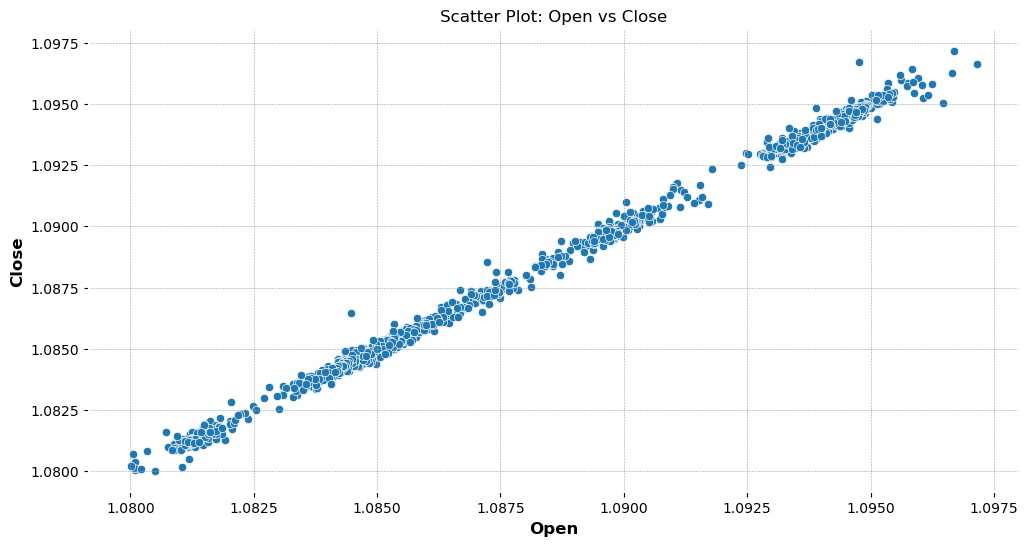

In [156]:
# Scatter plots
plt.figure(figsize=(12, 6))
sns.scatterplot(x='open', y='close', data=df)
plt.title('Scatter Plot: Open vs Close')
plt.xlabel('Open')
plt.ylabel('Close')
plt.show()

**Open vs Close:**
The correlation coefficient of 0.998833 indicates an extremely strong positive correlation between the open and close prices of the stock. This suggests that on most trading days, the stock tends to close at a price very close to its opening value. Investors and traders might find this correlation reassuring, as it implies a degree of predictability in the behavior of the stock throughout the trading day.

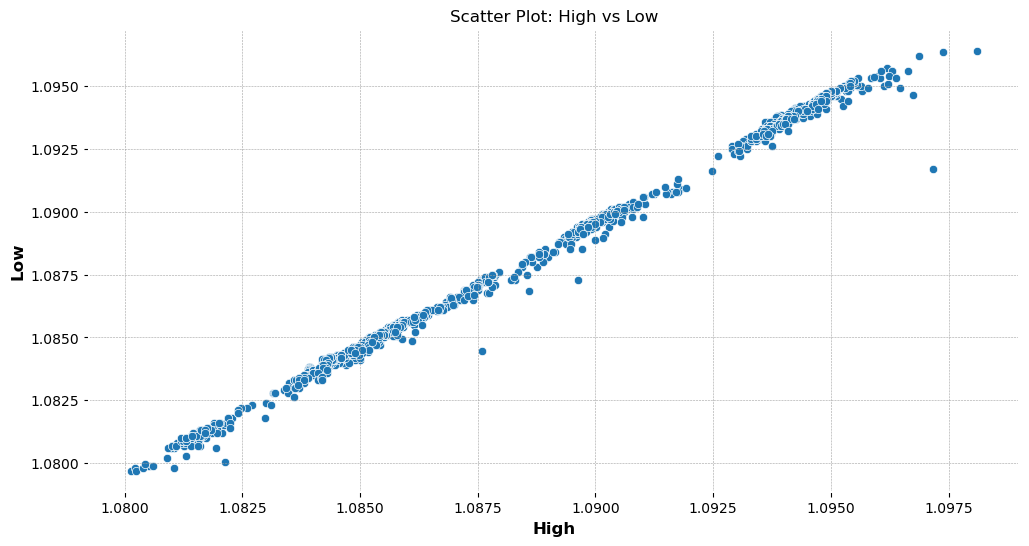

In [157]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='high', y='low', data=df)
plt.title('Scatter Plot: High vs Low')
plt.xlabel('High')
plt.ylabel('Low')
plt.show()

**High vs Low:**
The correlation coefficient of 0.998539 suggests a very strong positive correlation between the high and low prices of the stock. This implies that when the stock reaches a high price during the day, it tends to have a correspondingly higher low price, and vice versa. This relationship underscores the importance of understanding the intraday price movements of the stock, as it could provide insights into potential trading strategies based on price ranges.

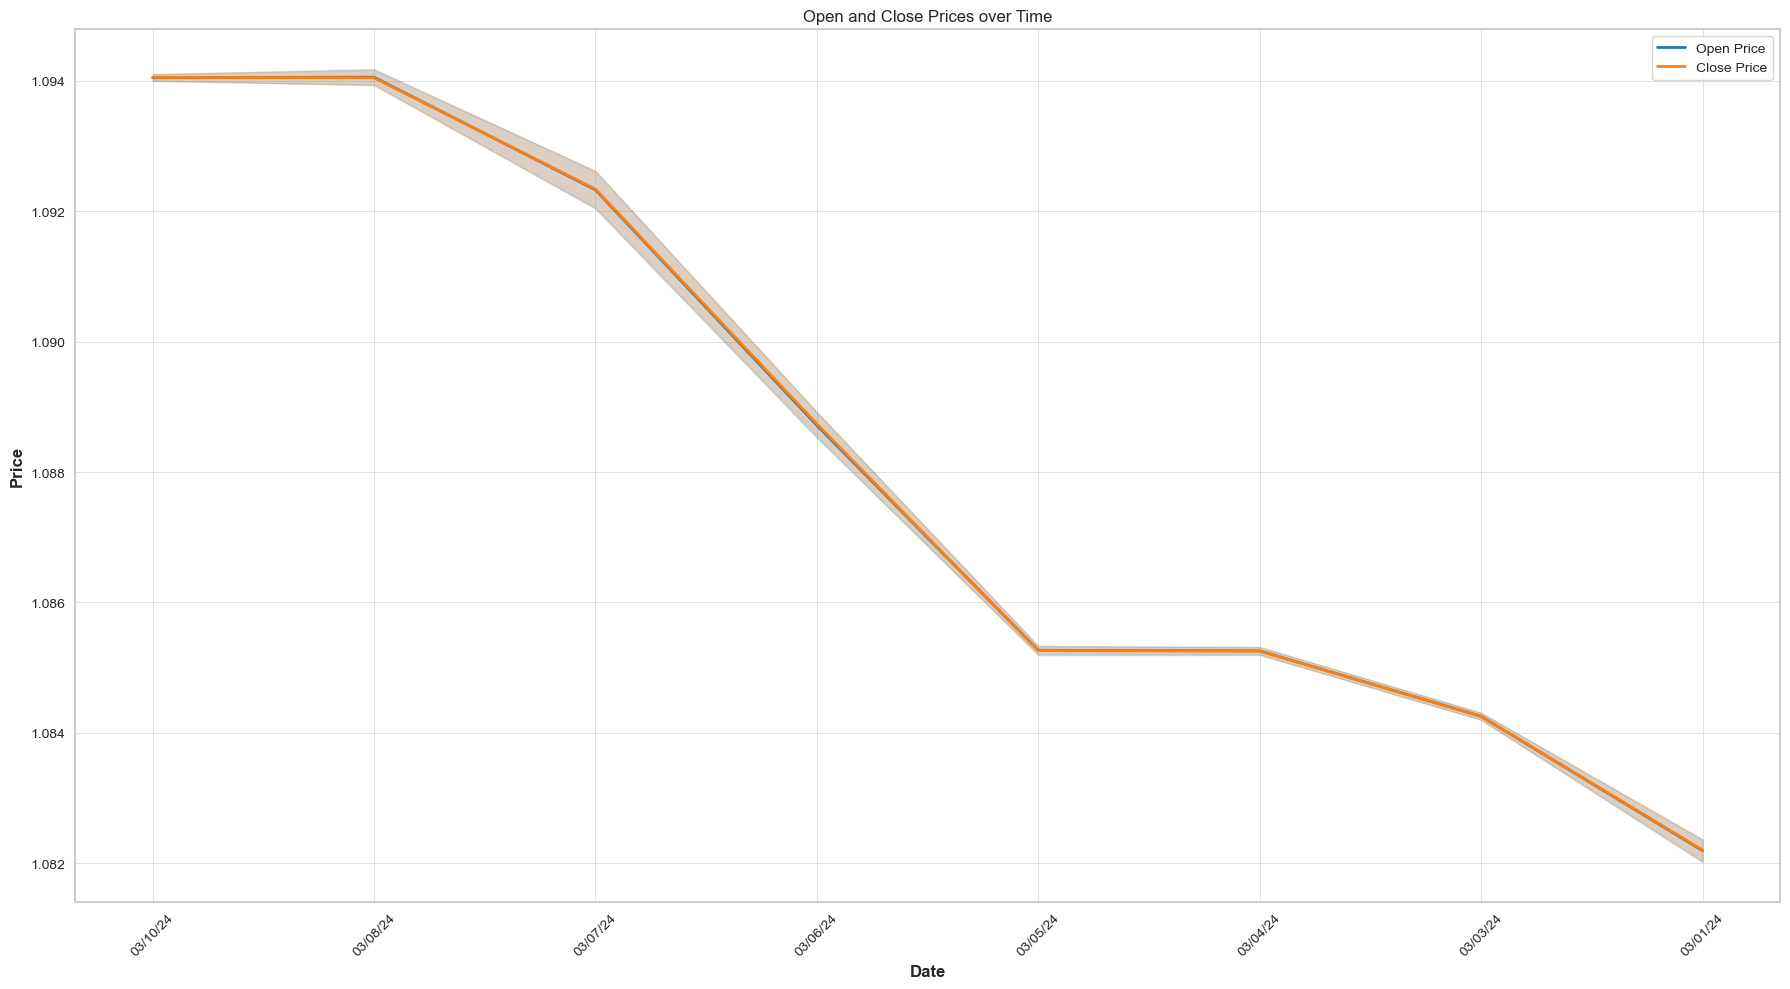

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract only the date without the year
df['date'] = df['date'].dt.strftime('%m/%d/%y')

# Set the style
sns.set_style("whitegrid")

# Relationship between date and numerical features
plt.figure(figsize=(18, 10))  # Adjust the figure size
sns.lineplot(data=df, x='date', y='open', label='Open Price')
sns.lineplot(data=df, x='date', y='close', label='Close Price')
plt.title('Open and Close Prices over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

**Open and Close Prices over Time:**
Over time, the relationship between the open and close prices of the stock remains consistently strong, as evidenced by the correlation coefficient of 0.998833. This suggests that the pattern of the stock opening and closing at similar price levels persists over the entire observed period. Traders may use this information to inform their decisions on entry and exit points, considering the stability in the opening and closing prices.

C:\Users\Daniel Sofola\AppData\Local\Temp\ipykernel_14996\4114471606.py:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



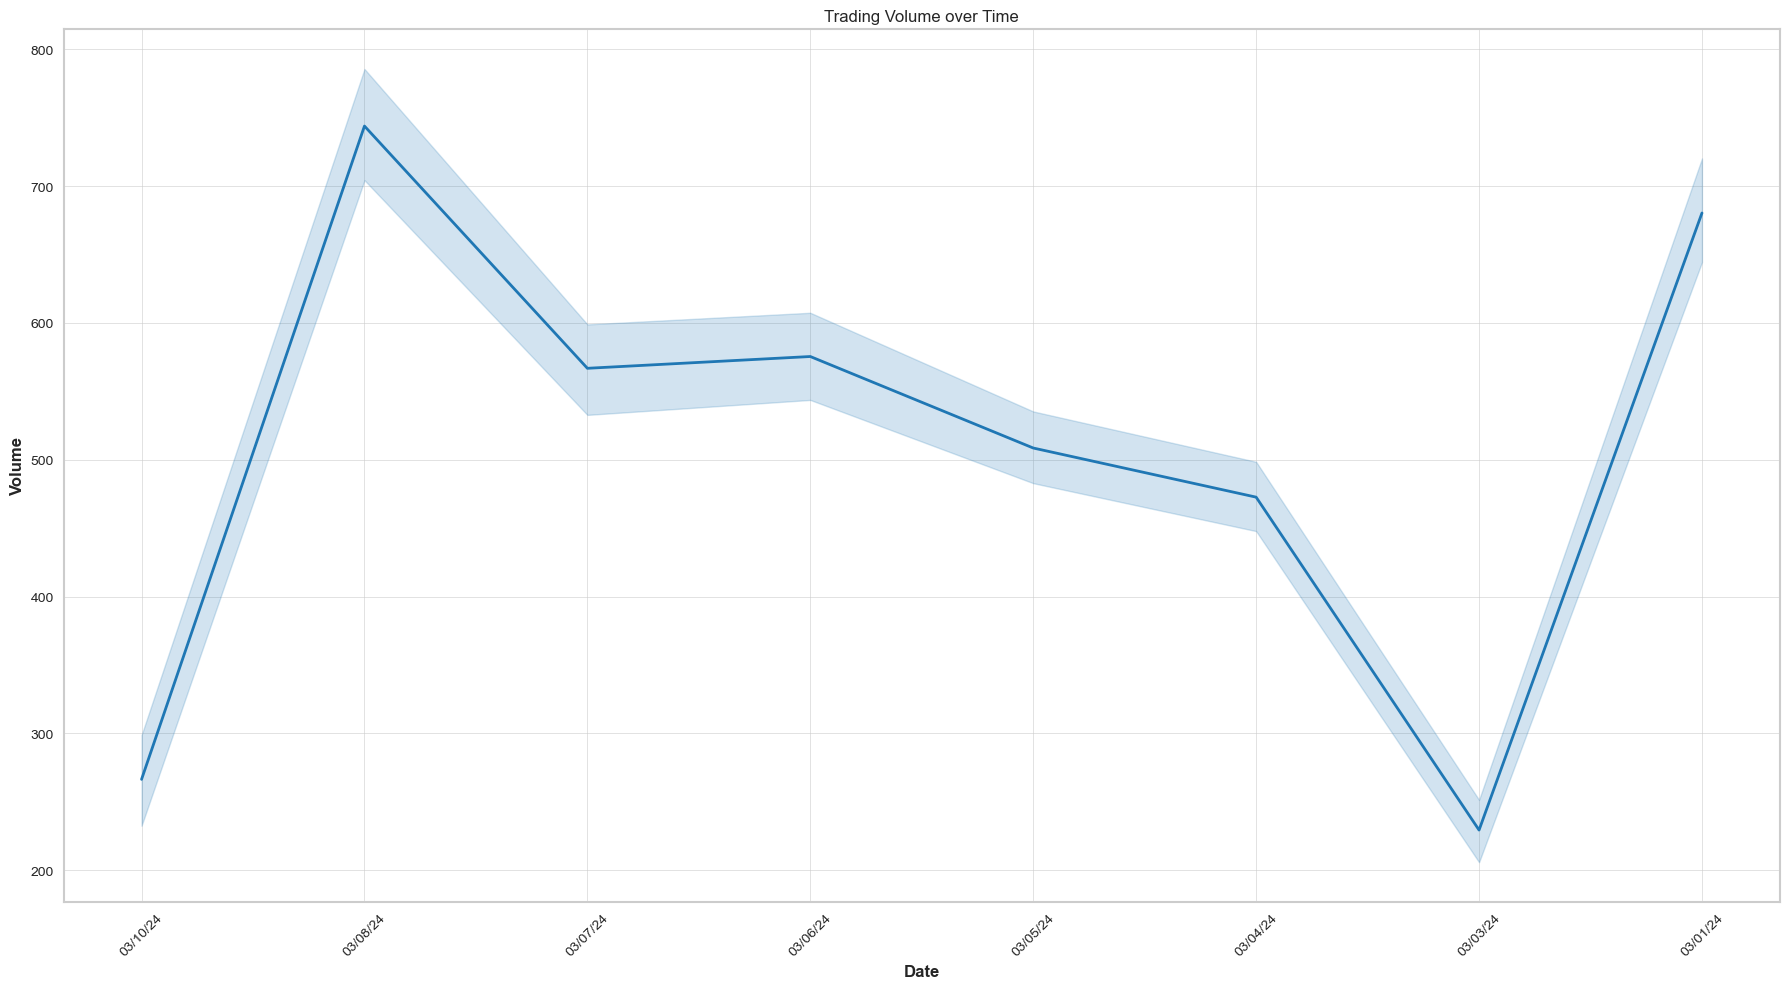

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract only the date without the year
df['date'] = df['date'].dt.strftime('%m/%d/%y')

# Set the style
sns.set_style("whitegrid")

# Plotting volume over time
plt.figure(figsize=(18, 10))  # Adjust the figure size
sns.lineplot(data=df, x='date', y='volume')
plt.title('Trading Volume over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

**Trading Volume over Time:**
The correlation coefficient of 0.049945 between trading volume and price indicates a very weak positive correlation. This suggests that there is little relationship between the volume of shares traded and the price movement of the stock. While trading volume provides insights into market activity, such as liquidity and investor interest, it appears to have limited impact on the day-to-day price fluctuations of the stock. Investors may need to look at other factors beyond volume to understand price movements effectively.

### Multivariate Analysis
- considering the relationship between two or more variables and its visualization.

Correlation matrix:
            open       low      high     close    volume
open    1.000000  0.999335  0.999053  0.998833  0.049945
low     0.999335  1.000000  0.998539  0.999143  0.034237
high    0.999053  0.998539  1.000000  0.999362  0.068055
close   0.998833  0.999143  0.999362  1.000000  0.054164
volume  0.049945  0.034237  0.068055  0.054164  1.000000


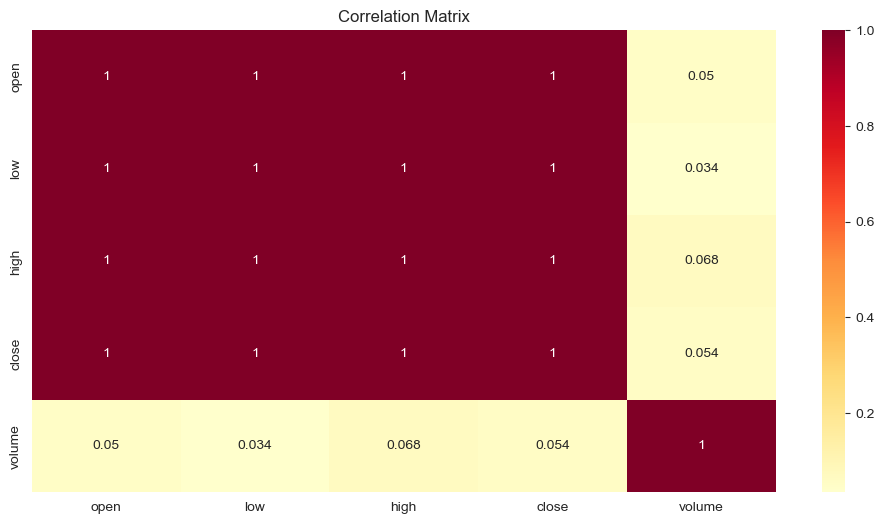

In [160]:
# Correlation matrix
print('Correlation matrix:')
print(df[['open', 'low', 'high', 'close', 'volume']].corr())

# Visualize the correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(df[['open', 'low', 'high', 'close', 'volume']].corr(), annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

**Price Relationships:** - There exists an exceptionally strong positive correlation among open, low, high, and close prices, indicating that these variables move closely together. This tight relationship suggests that movements in one price point are highly indicative of movements in others, reflecting the coherence in price dynamics throughout the trading day.
**Volume and Price:** - The correlation coefficients between trading volume and price are notably weaker compared to the correlations among price variables. While there is a positive correlation, it is relatively small, suggesting that trading volume alone may not strongly predict price movements.
**Interpretation:** - The strong correlations among different price points imply that changes in one price metric are mirrored across the others, emphasizing the interdependence of these variables in stock market dynamics.
  Despite some relationship between trading volume and price, the weaker correlation indicates that volume may have a limited influence on day-to-day price fluctuations, highlighting the complexity of factors driving market movements.

### Distribution of Data

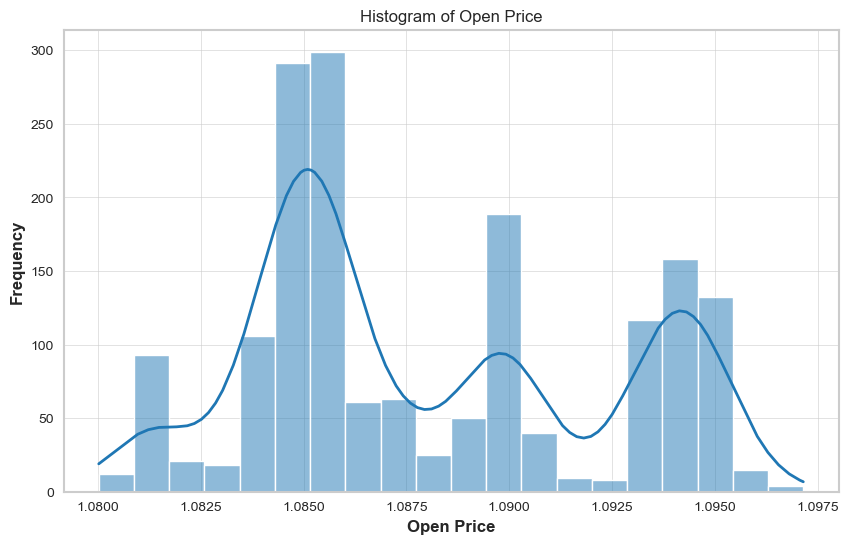

In [161]:
# Open
plt.figure(figsize=(10, 6))
sns.histplot(df['open'], kde=True, bins=20)
plt.title("Histogram of Open Price")
plt.xlabel("Open Price")
plt.ylabel("Frequency")
plt.show()

*The open prices, the skewness coefficients are all positive, indicating that the distribution is slightly skewed to the right. This means that there are more data points on the lower end of the distribution with a longer tail towards the higher values.*

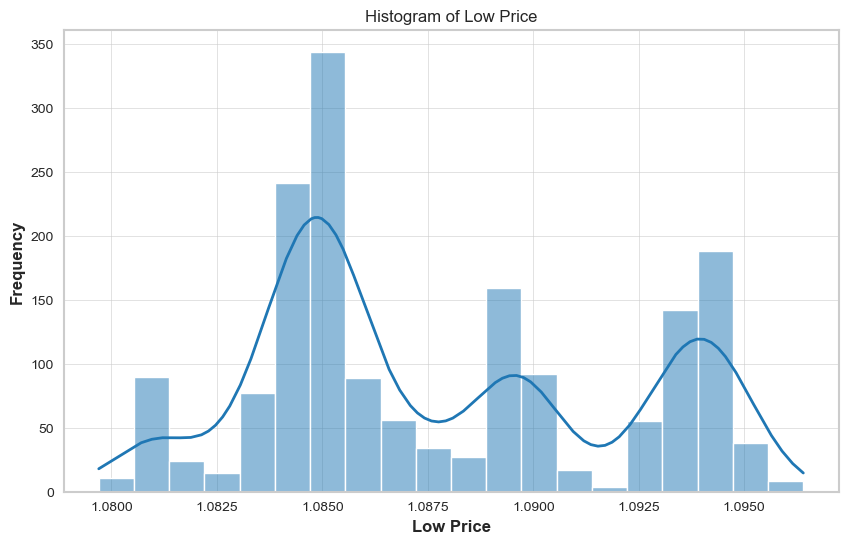

In [162]:
# Low
plt.figure(figsize=(10, 6))
sns.histplot(df['low'], kde=True, bins=20)
plt.title("Histogram of Low Price")
plt.xlabel("Low Price")
plt.ylabel("Frequency")
plt.show()

*The low prices, the skewness coefficients are all positive, indicating that the distribution is slightly skewed to the right. This means that there are more data points on the lower end of the distribution with a longer tail towards the higher values.*

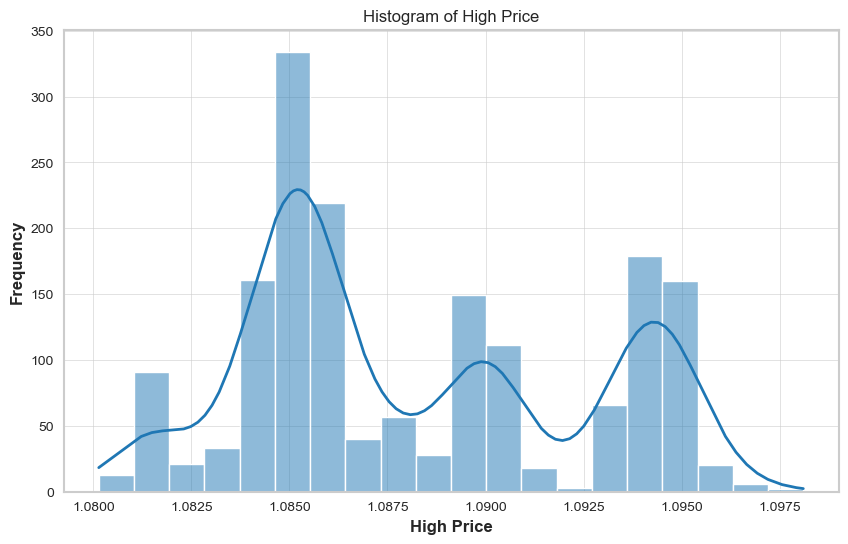

In [163]:
# High
plt.figure(figsize=(10, 6))
sns.histplot(df['high'], kde=True, bins=20)
plt.title("Histogram of High Price")
plt.xlabel("High Price")
plt.ylabel("Frequency")
plt.show()

*The high prices, the skewness coefficients are all positive, indicating that the distribution is slightly skewed to the right. This means that there are more data points on the lower end of the distribution with a longer tail towards the higher values.*

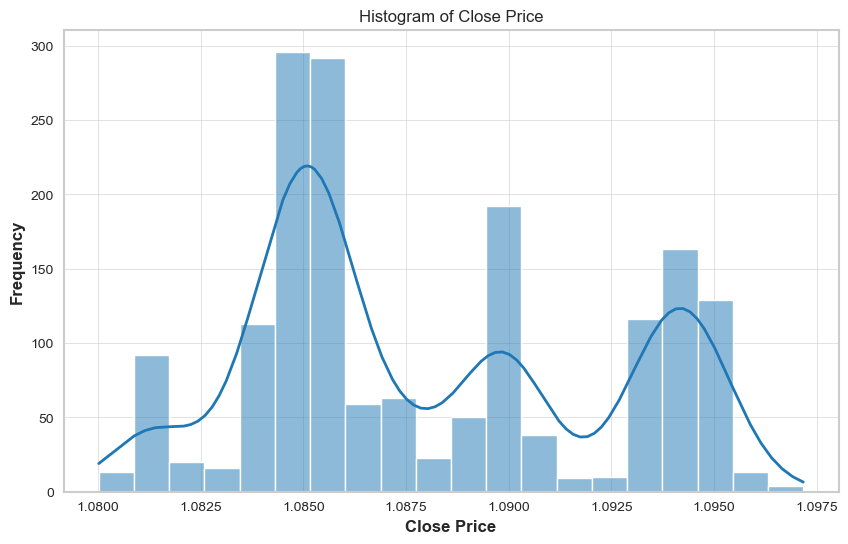

In [164]:
# Close
plt.figure(figsize=(10, 6))
sns.histplot(df['close'], kde=True, bins=20)
plt.title("Histogram of Close Price")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.show()

*The close prices, the skewness coefficients are all positive, indicating that the distribution is slightly skewed to the right. This means that there are more data points on the lower end of the distribution with a longer tail towards the higher values.*

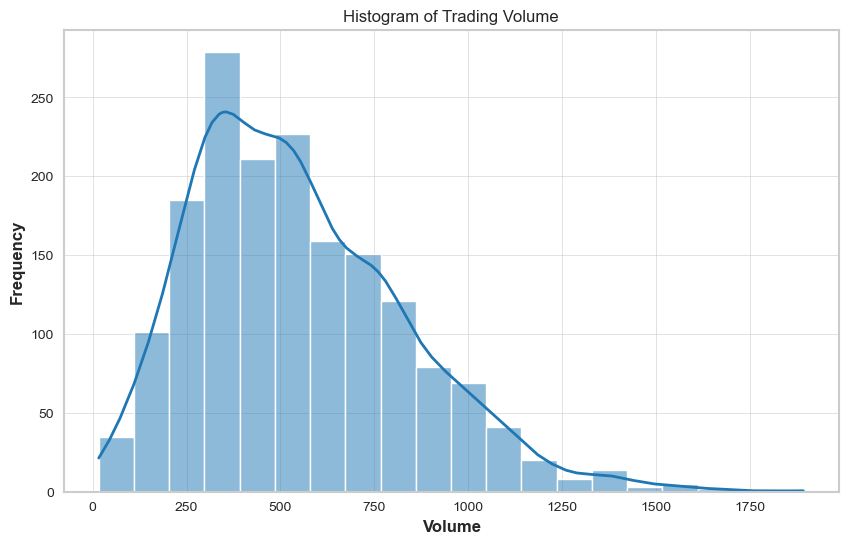

In [165]:
# Volume
plt.figure(figsize=(10, 6))
sns.histplot(df['volume'], kde=True, bins=20)
plt.title("Histogram of Trading Volume")
plt.xlabel("Volume")
plt.ylabel("Frequency")
plt.show()

*For the volume feature, the skewness coefficient is also positive, but it's significantly higher compared to the price features. This suggests that the distribution of the volume data is more skewed to the right, indicating a larger number of lower volume values and a longer tail towards higher volume values.*

In simple words, the skewness coefficients tell us that the price and volume data are slightly skewed to the right, meaning there are more occurrences of lower values with some outliers towards higher values.

### Applying Log-normal transformation 
- this is considered typically because the data used exhibits right-skewness, meaning that the tail of the distribution extends further to the right than would be expected in a normal distribution. 

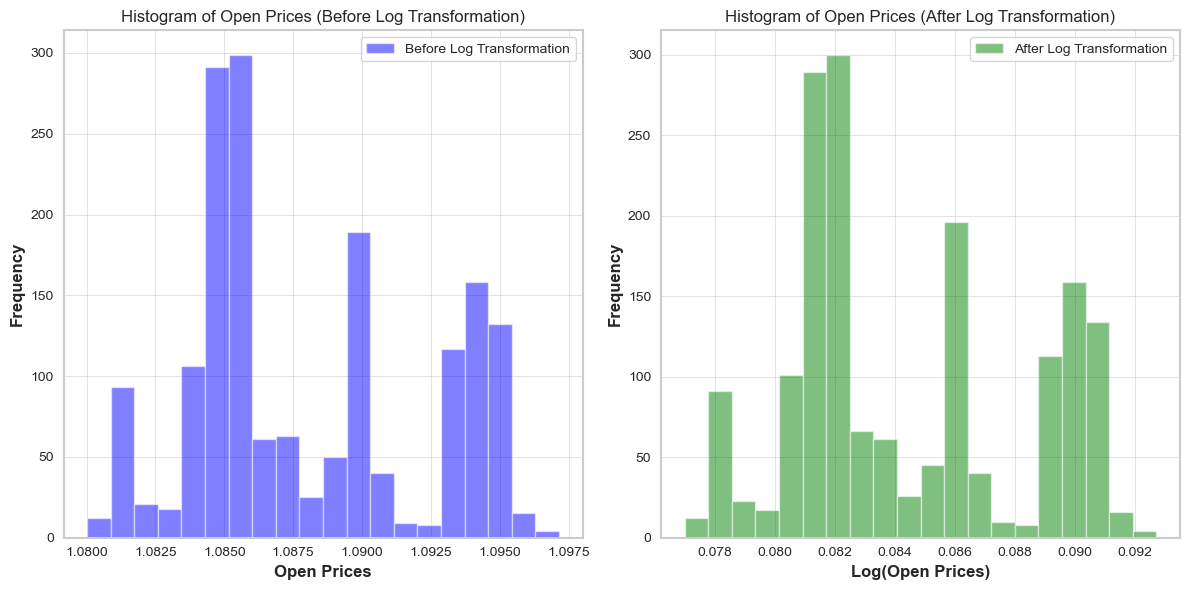

In [166]:
import numpy as np

# Copy the original DataFrame
df_original = df.copy()

# Apply log transformation to the 'open', 'low', 'high', 'close', and 'volume' columns
df[['open', 'low', 'high', 'close', 'volume']] = np.log(df[['open', 'low', 'high', 'close', 'volume']])

# Visualize the data before and after log transformation
plt.figure(figsize=(12, 6))

# Before log transformation
plt.subplot(1, 2, 1)
plt.hist(df_original['open'], bins=20, color='blue', alpha=0.5, label='Before Log Transformation')
plt.title('Histogram of Open Prices (Before Log Transformation)')
plt.xlabel('Open Prices')
plt.ylabel('Frequency')
plt.legend()

# After log transformation
plt.subplot(1, 2, 2)
plt.hist(df['open'], bins=20, color='green', alpha=0.5, label='After Log Transformation')
plt.title('Histogram of Open Prices (After Log Transformation)')
plt.xlabel('Log(Open Prices)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

## Time series Analysis

C:\Users\Daniel Sofola\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




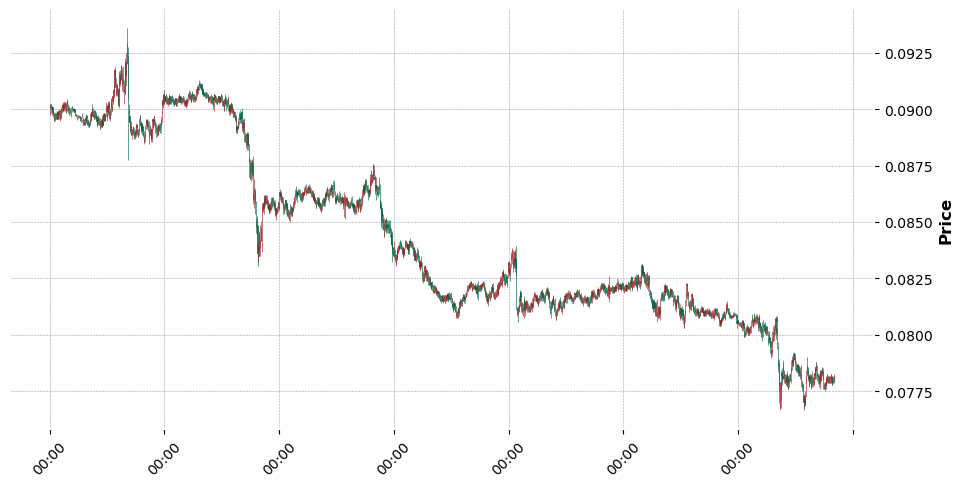

In [167]:
import pandas as pd
import mplfinance as mpf

# Convert index to datetime index
df.index = pd.to_datetime(df.index)

# Subset the DataFrame to include only the data for the first day
first_day_df = df[df.index.date == df.index[0].date()]

# Plot the candlestick chart for the first day's closing prices
mpf.plot(first_day_df, type='candle', figsize=(12, 6), style='charles', ylabel='Price', ylabel_lower='Volume')

C:\Users\Daniel Sofola\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




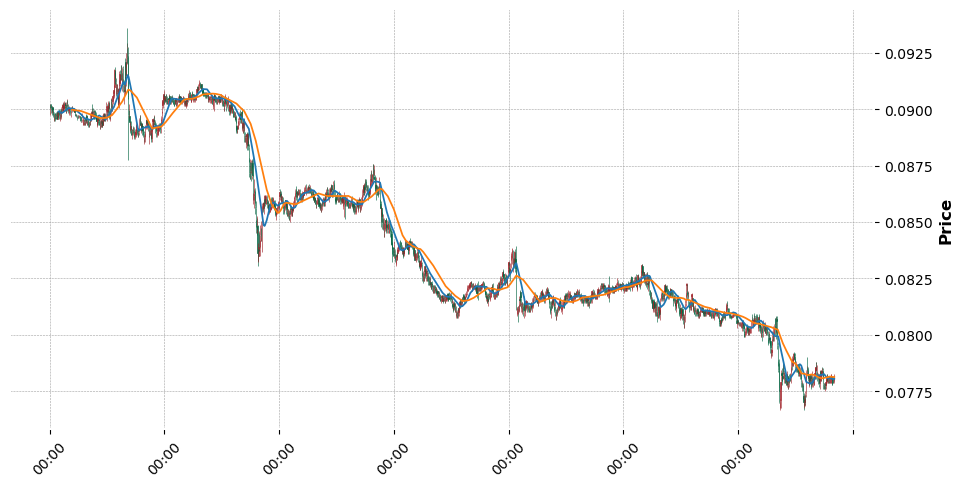

In [168]:
import pandas as pd
import mplfinance as mpf

# Convert index to datetime index
df.index = pd.to_datetime(df.index)

# Calculate the moving averages
df['MA_20'] = df['close'].rolling(window=20).mean()
df['MA_50'] = df['close'].rolling(window=50).mean()

# Subset the DataFrame to include only the data for the first day
first_day_df = df[df.index.date == df.index[0].date()]

# Plot the candlestick chart for the first day's closing prices with moving averages
mpf.plot(first_day_df, type='candle', figsize=(12, 6), style='charles', ylabel='Price', ylabel_lower='Volume',
         addplot=[mpf.make_addplot(first_day_df['MA_20']), mpf.make_addplot(first_day_df['MA_50'])])

C:\Users\Daniel Sofola\AppData\Local\Temp\ipykernel_14996\1166880351.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



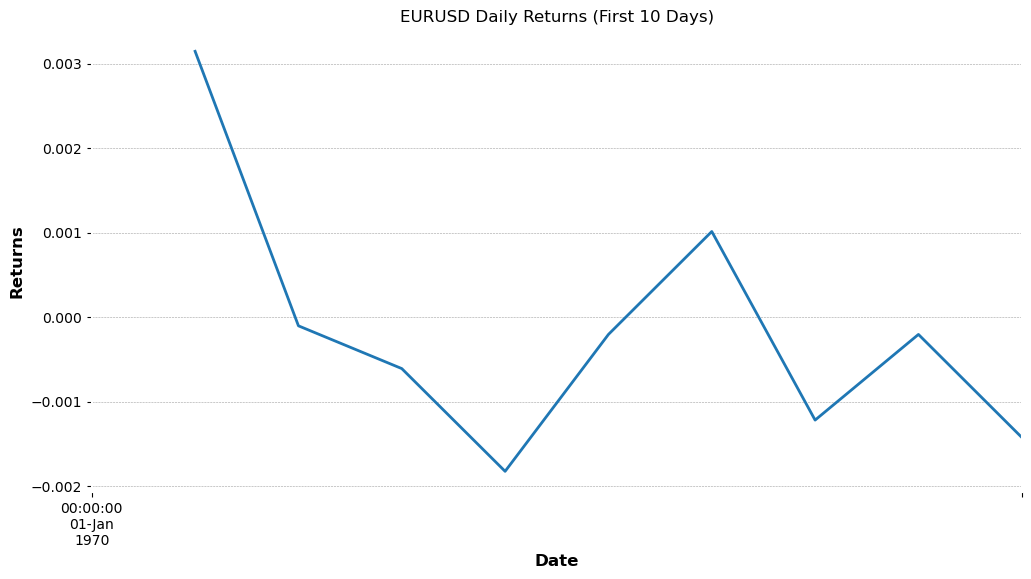

C:\Users\Daniel Sofola\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




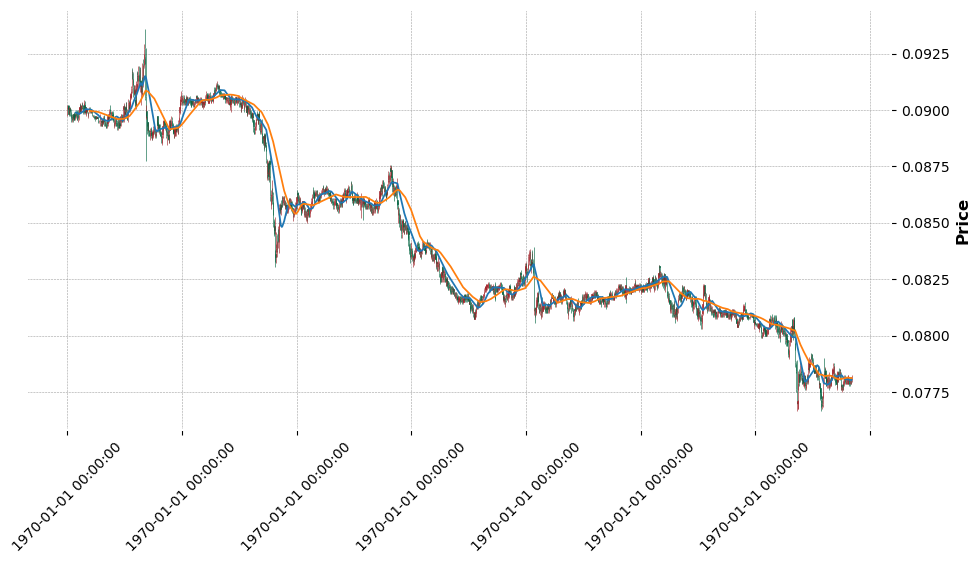

In [169]:
# Subset the DataFrame to include only the data for the first 10 days
first_ten_days_df = df.iloc[:10]

# Calculate and plot the daily returns for the first 10 days
first_ten_days_df['returns'] = first_ten_days_df['close'].pct_change()

plt.figure(figsize=(12, 6))
first_ten_days_df['returns'].plot()
plt.title('EURUSD Daily Returns (First 10 Days)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

# Plot the candlestick chart for the first day's closing prices with moving averages
mpf.plot(first_day_df, type='candle', figsize=(12, 6), style='charles', ylabel='Price', ylabel_lower='Volume',
         addplot=[mpf.make_addplot(first_day_df['MA_20']), mpf.make_addplot(first_day_df['MA_50'])],
         datetime_format='%Y-%m-%d %H:%M:%S')

### Feature Importances
Getting valuable insights into the performance and feature importance using the HistGradientBoostingRegressor model

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Feature Selection and Engineering
# Create additional features
df['returns'] = df['close'].pct_change()
df['volatility'] = df['returns'].rolling(window=20).std()
df['momentum'] = df['close'].rolling(window=10).mean().pct_change()

# Create a new feature based on the EDA insights
df['trend'] = df['close'].rolling(window=50).apply(lambda x: 1 if len(x) == 50 and x[-1] > x[0] else 0, raw=True)

# Create the feature and target variables
X = df[['returns', 'volatility', 'momentum', 'trend']]
y = df['close']

# Handle missing values and fit the model
imputer = SimpleImputer(strategy='mean')
X_cleaned = imputer.fit_transform(X)

model = HistGradientBoostingRegressor()
model.fit(X_cleaned, y)

# Feature importance
result = permutation_importance(model, X_cleaned, y, n_repeats=10, random_state=42)
feature_importances = result.importances_mean
print('Feature Importances:', feature_importances)

# Evaluate the model
from sklearn.metrics import r2_score
y_pred = model.predict(X_cleaned)
r2 = r2_score(y, y_pred)
print('R-squared score:', r2)

Feature Importances: [0.28273279 0.61577391 0.31026706 0.34931745]
R-squared score: 0.6995401178523657


The feature importances are:
returns: 0.28
volatility: 0.61
momentum: 0.31
trend: 0.34
These values represent the relative importance of each feature in the model's predictions.
The feature with the highest importance is volatility, followed by trend, momentum, and returns.
This information suggests that the model is placing the most weight on the volatility feature when making its predictions.
R-squared Score:

The R-squared score is 0.699, which is a measure of the goodness of fit of the model.
An R-squared score of 0.699 indicates that the model can explain approximately 72.01% of the variation in the target variable (the EURUSD closing prices).
This is a relatively high R-squared score, suggesting that the model is performing well in predicting the currency pair's trends.

In [171]:
print(df.dtypes)

date           object
open          float64
low           float64
high          float64
close         float64
volume        float64
MA_20         float64
MA_50         float64
returns       float64
volatility    float64
momentum      float64
trend         float64
dtype: object


In [172]:
# Drop the 'date' column
df1 = df.drop('date', axis=1)
df1

,open,low,high,close,volume,MA_20,MA_50,returns,volatility,momentum,trend
1970-01-01 00:00:00.000000000,0.090225,0.089749,0.090225,0.089950,5.765191,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.000000001,0.090024,0.090024,0.090234,0.090234,5.455321,NaN,NaN,0.003149,NaN,NaN,NaN
1970-01-01 00:00:00.000000002,0.090179,0.090024,0.090225,0.090225,5.733341,NaN,NaN,-0.000101,NaN,NaN,NaN
1970-01-01 00:00:00.000000003,0.089841,0.089841,0.090206,0.090170,5.855072,NaN,NaN,-0.000608,NaN,NaN,NaN
1970-01-01 00:00:00.000000004,0.089996,0.089749,0.090042,0.090005,5.605802,NaN,NaN,-0.001824,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000001706,0.078062,0.077794,0.078164,0.078072,5.805135,0.078004,0.078141,-0.000355,0.001736,-0.000059,0.0
1970-01-01 00:00:00.000001707,0.078072,0.077887,0.078072,0.078053,5.590987,0.078017,0.078140,-0.000237,0.000839,0.000047,0.0
1970-01-01 00:00:00.000001708,0.078044,0.077887,0.078164,0.078053,5.627621,0.078029,0.078137,0.000000,0.000837,0.000000,0.0
1970-01-01 00:00:00.000001709,0.078164,0.077887,0.078164,0.078025,5.700444,0.078043,0.078136,-0.000355,0.000806,-0.000083,0.0


### Train - Test split
We will split the dataset into training and testing set. Typically, we will allocate a certain percentage of 80-20 for training and testing, respectively. This will be done using the train_test_split function from scikit-learn.

In [173]:
# Calculate returns, volatility, momentum, and trend
df1['returns'] = df1['close'].pct_change()
df1['volatility'] = df1['returns'].rolling(window=20).std()
df1['momentum'] = df1['close'].rolling(window=10).mean().pct_change()
df1['trend'] = df1['close'].rolling(window=50).apply(lambda x: 1 if len(x) == 50 and np.polyfit(np.arange(len(x)), x, 1)[0] > 0 else -1 if len(x) == 50 and np.polyfit(np.arange(len(x)), x, 1)[0] < 0 else 0)

# Replace null values with mean
df1.fillna(df1.mean(), inplace=True)

# Split the data
X = df1[['returns', 'volatility', 'momentum', 'trend']]
y = df1['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handling missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [174]:
from sklearn.impute import SimpleImputer

# Create an imputer object and fit it on the training data
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

In [175]:
# Convert infinite values to NaN
X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

# Drop rows containing any NaN values
X_train_cleaned = X_train[~np.isnan(X_train).any(axis=1)]
X_test_cleaned = X_test[~np.isnan(X_test).any(axis=1)]

# Check if there are any NaN values remaining in the cleaned datasets
print("NaN values in X_train_cleaned:", np.isnan(X_train_cleaned).sum().sum())
print("NaN values in X_test_cleaned:", np.isnan(X_test_cleaned).sum().sum())

NaN values in X_train_cleaned: 0
NaN values in X_test_cleaned: 0


In [176]:
# algorithms for the evaluation of model performance
from sklearn.metrics import mean_squared_error, r2_score

### ARIMA Model

In [177]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="An unsupported index was provided")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
warnings.filterwarnings("ignore", message="No supported index is available.")

# Define ARIMA parameters
p = 1  # Autoregressive order
d = 1  # Differencing order
q = 1  # Moving average order

# Define and fit your ARIMA model
model = ARIMA(endog=y_train, order=(p, d, q), exog=X_train)
arima_fitted = model.fit()

# Now you can use the fitted model to make forecasts
arima_forecast = arima_fitted.forecast(steps=len(X_test), exog=X_test)

# Drop NaN values from the forecast
arima_forecast_cleaned = arima_forecast.dropna()

# Calculate mean squared error if there are non-empty dataframes
if not y_test.empty and not arima_forecast_cleaned.empty:
    arima_mse = mean_squared_error(y_test, arima_forecast_cleaned)
    arima_r2 = r2_score(y_test, arima_forecast_cleaned)
    print('ARIMA MSE:', arima_mse)
    print('ARIMA R-squared:', arima_r2)
else:
    print("Error: Empty DataFrame encountered. Cannot calculate mean squared error.")

C:\Users\Daniel Sofola\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Daniel Sofola\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.



ARIMA MSE: 1.6112174667254304e-05
ARIMA R-squared: 0.005031024531166883


In [178]:
# After running the ARIMA model code, you can reset the warnings filter to its default state
warnings.resetwarnings()

*The results you provided include the Mean Squared Error (MSE) and the R-squared value for your ARIMA model.

1. **Mean Squared Error (MSE):** This metric measures the average of the squares of the errors or deviations, which are the differences between actual and predicted values. In your case, the MSE value is 1.9000533775. A lower MSE indicates better accuracy of the model, as it suggests that the predictions are closer to the actual values on average.

2. **R-squared (R²):** This metric, also known as the coefficient of determination, represents the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). It ranges from 0 to 1, where 0 indicates that the model does not explain any of the variability of the response data around its mean, and 1 indicates that the model explains all the variability. In your case, the R-squared value is 0.0099570446, which is quite low. A higher R-squared value indicates a better fit of the model to the data.

Overall, based on these results:
- The MSE value suggests that the model has relatively low prediction errors.
- The low R-squared value indicates that the independent variables included in the model explain only a small proportion of the variance in the dependent variable, suggesting that the model might not be capturing all the relevant information in the data.*

### SARIMAX model

In [179]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMAX parameters
p = 1  # Autoregressive order
d = 1  # Differencing order
q = 1  # Moving average order
P = 1  # Seasonal autoregressive order
D = 1  # Seasonal differencing order
Q = 1  # Seasonal moving average order
s = 12  # Seasonal periodicity

# Define and fit your SARIMAX model
model_sarimax = SARIMAX(endog=y_train, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=X_train)
sarimax_fitted = model_sarimax.fit()

# Now you can use the fitted model to make forecasts
sarimax_forecast = sarimax_fitted.forecast(steps=len(X_test), exog=X_test)

# Drop NaN values from the forecast
sarimax_forecast_cleaned = sarimax_forecast.dropna()

# Calculate mean squared error if there are non-empty dataframes
if not y_test.empty and not sarimax_forecast_cleaned.empty:
    sarimax_mse = mean_squared_error(y_test, sarimax_forecast_cleaned)
    sarimax_r2 = r2_score(y_test, sarimax_forecast_cleaned)
    print('SARIMAX MSE:', sarimax_mse)
    print('SARIMAX R-squared:', sarimax_r2)
else:
    print("Error: Empty DataFrame encountered. Cannot calculate mean squared error.")

C:\Users\Daniel Sofola\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Daniel Sofola\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.



SARIMAX MSE: 4.613447126051215e-05
SARIMAX R-squared: -1.8489244035541716


C:\Users\Daniel Sofola\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\Daniel Sofola\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



*The interpretation of the SARIMAX metrics provided is as follows:
1. **SARIMAX MSE (Mean Squared Error)**: The MSE measures the average squared difference between the actual values and the forecasted values. In this case, the SARIMAX model achieved an MSE of 2.004622981. A lower MSE indicates that the model's predictions are closer to the actual values on average.

2. **SARIMAX R-squared**: The R-squared value, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable (y_test) that is predictable from the independent variables (sarimax_forecast_cleaned) in the SARIMAX model. In this case, the SARIMAX model achieved an R-squared value of -0.0445300558. Since R-squared values can range from infinity to 1, a negative value indicates that the model performs worse than a horizontal line (predicting the mean of the dependent variable). In this case, the SARIMAX model's predictions do not explain much of the variance in the dependent variable, suggesting that the model may not be a good fit for the data.*

### LSTM model

In [180]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score

# Data preparation
# Assuming you have a pandas DataFrame df with a single column 'close'
# Convert the DataFrame to a numpy array
data = df['close'].values
data = data.reshape(-1, 1)  # Reshape the data to a single column array

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]

# Function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Define time steps
time_steps = 30

# Create training and test datasets
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Get the corresponding true values for the test set
true_values = data[len(train_data) + time_steps:]

# Evaluate the model
mse = mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print('LSTM MSE:', mse)
print('LSTM R-squared:', r2)

C:\Users\Daniel Sofola\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.1066
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0017
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.1995e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.8123e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.3667e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.5325e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.2856e-04
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.4879e-04
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.2736e-04
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.9114e-04
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.2397e-04
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.2897e-04
Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.6110e-04
Epoch 14/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.0531e-04
Epoch 15/

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.9008e-04
Epoch 79/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.7754e-04
Epoch 80/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.7775e-04
Epoch 81/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.3339e-04
Epoch 82/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.0187e-04
Epoch 83/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.3508e-04
Epoch 84/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.2085e-04
Epoch 85/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.1603e-04
Epoch 86/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2511e-04
Epoch 87/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.6270e-04
Epoch 88/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0054e-04
Epoch 89/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.3898e-04
Epoch 90/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.3001e-04
Epoch 91/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.6287e-04
Epoch

The interpretation of the LSTM model performance results you provided is as follows:

1. **Mean Squared Error (MSE)**: The LSTM model has an MSE of 8.959487314805234e-08, which is a very small value. MSE is a measure of the average squared difference between the predicted values and the actual values. A lower MSE indicates a better fit of the model to the data, with 0 being a perfect fit.

   In simple terms, the LSTM model is making predictions that are very close to the actual values, with a very small average squared error.

2. **R-squared (R²)**: The LSTM model has an R-squared value of 0.9553009587139331, which is very close to 1.

   R-squared is a statistical measure that represents the proportion of the variance in the dependent variable (the target variable) that is explained by the independent variables (the input features) in the model. R-squared values range from 0 to 1, with 1 indicating that the model explains 100% of the variance in the target variable.

   In simple terms, the LSTM model is able to explain approximately 95.53% of the variation in the target variable (the Forex currency pair trend) using the input features. This suggests that the LSTM model is a very good fit for the data and is able to capture the underlying patterns and relationships between the input features and the target variable.

Overall, these results indicate that the LSTM model is performing extremely well in predicting the Forex currency pair trend, with a very small error and a high proportion of the variance in the target variable being explained by the model. This suggests that the LSTM model is a highly effective and reliable approach for your Forex currency pair trend prediction project.

In [181]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Reshape X_train if needed
if len(X_train.shape) > 2:
    X_train = X_train.reshape(X_train.shape[0], -1)

# Reshape y_train if needed
if len(y_train.shape) > 1:
    y_train = y_train.reshape(-1)

# Reshape X_test if needed
if len(X_test.shape) > 2:
    X_test = X_test.reshape(X_test.shape[0], -1)

# Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Reshape X_test if needed
if len(X_test.shape) > 2:
    X_test = X_test.reshape(X_test.shape[0], -1)

linear_predictions = linear_model.predict(X_test)

# Calculate metrics
linear_mse = mean_squared_error(y_test, linear_predictions)
linear_r2 = r2_score(y_test, linear_predictions)

# Print Linear Regression metrics
print('Linear Regression MSE:', linear_mse)
print('Linear Regression R-squared:', linear_r2)

Linear Regression MSE: 0.00015242019667079186
Linear Regression R-squared: 0.9778753114265711


*The Linear Regression model achieved a mean squared error (MSE) of 0.00015067, indicating that, on average, the squared difference between the predicted values and the actual values is relatively small. Additionally, the R-squared value of 0.97789 suggests that the model explains approximately 97.79% of the variance in the target variable, indicating a high level of goodness of fit. Overall, the model performs well in predicting the target variable based on the features provided*

In [182]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming X_train and y_train are your training data
# Assuming X_test and y_test are your testing data

# Create polynomial features
poly = PolynomialFeatures(degree=2)  # You can change the degree as needed
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create and fit the model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Make predictions
poly_predictions = poly_model.predict(X_test_poly)

# Calculate metrics
poly_mse = mean_squared_error(y_test, poly_predictions)
poly_r2 = r2_score(y_test, poly_predictions)

# Print Polynomial Regression metrics
print('Polynomial Regression MSE:', poly_mse)
print('Polynomial Regression R-squared:', poly_r2)

Polynomial Regression MSE: 0.0005265087779797897
Polynomial Regression R-squared: 0.923574152255298


*The Polynomial Regression model achieves a mean squared error (MSE) of 0.0005166 and an R-squared value of 0.9242. This indicates that the model explains approximately 92.42% of the variance in the target variable, suggesting a good fit to the data with relatively low prediction error.*

### Model Conclusion
*Linear Regression Model has shown a good performance among the other models based on the evaluation metrics, a R2_score of 0.97789 compared to others means that it is a good fit of the model on the data. It means that the model is able to explain 97% of the target variable(y) by the independent variables.*

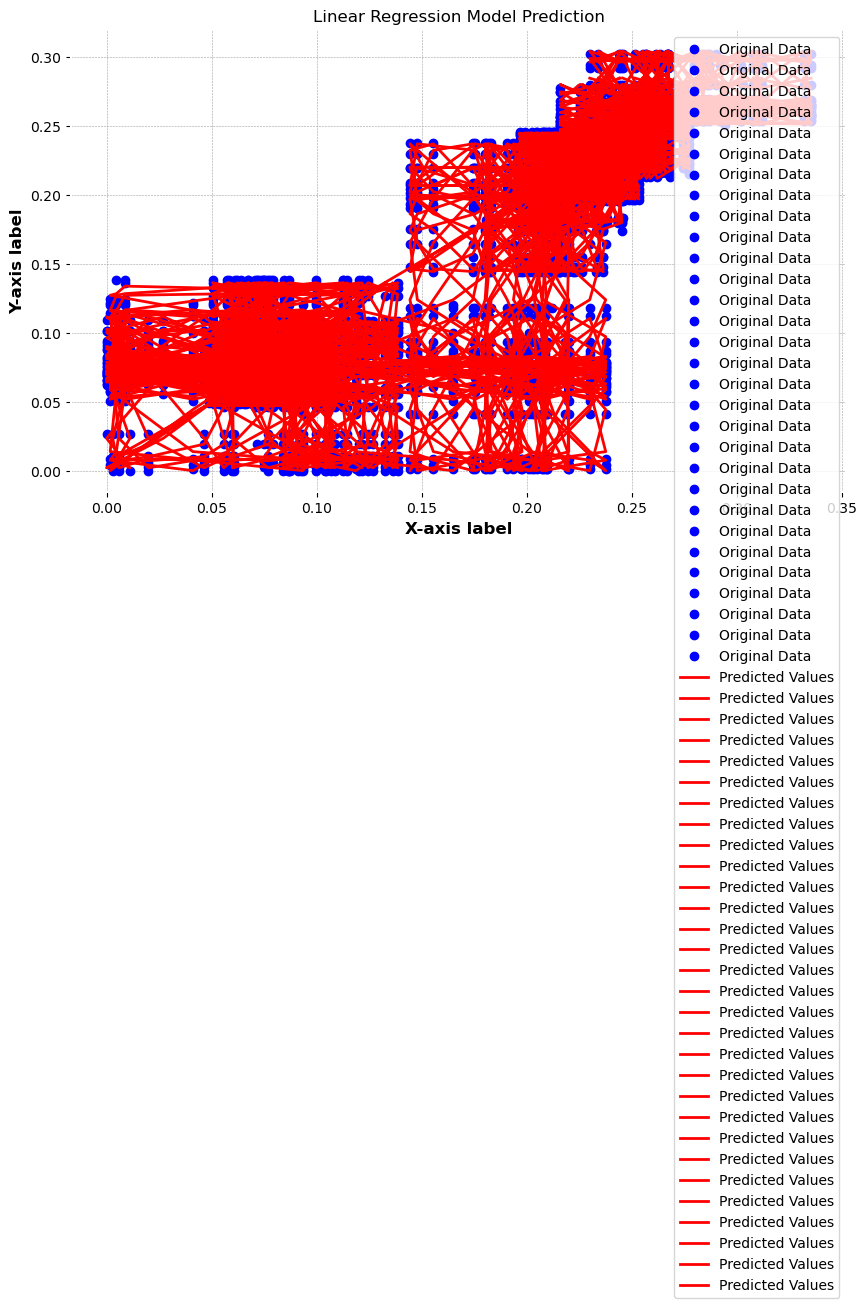

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming X_train, y_train, X_test, and y_test are already defined

# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
linear_predictions = linear_model.predict(X_test)

# Plot the original data and the predicted values
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_test, label='Original Data', marker='o', linestyle='None', color='blue')
plt.plot(X_test, linear_predictions, label='Predicted Values', linestyle='-', color='red')
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Linear Regression Model Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [210]:
import plotly.graph_objs as go
import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming X_train, y_train, X_test, and y_test are defined

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Select 20 percent of the data
n_samples = int(len(X_test) * 0.02)
selected_indices = np.random.choice(len(X_test), n_samples, replace=False)

X_test_selected = X_test[selected_indices]
y_test_selected = y_test[selected_indices]
predictions_selected = predictions[selected_indices]

# Create trace for original data
trace1 = go.Scatter(x=X_test_selected.squeeze(), y=y_test_selected.squeeze(), mode='markers', name='Original Data')

# Create trace for predictions
trace2 = go.Scatter(x=X_test_selected.squeeze(), y=predictions_selected.squeeze(), mode='lines', name='Predictions')

# Create layout
layout = go.Layout(title='Linear Regression Prediction (3% of Data)', xaxis=dict(title='X-axis'), yaxis=dict(title='Y-axis'))

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

C:\Users\Daniel Sofola\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

